<a href="https://colab.research.google.com/github/QSRafael/desafios-nlp/blob/master/receipts/DesafioMostQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio mostQi - Recibos de Pagamento

Rafael de Queiroz Souza

Nesse desafio, está sendo usado o dataset SRIOE, que contém 626 recibos escaneados e rotulados para treino, e 347 para teste.

Usarei o modelo pré-treinado LayoutLMv2 proposto por Yang Xu, Yiheng Xu, Tengchao Lv, Lei Cui, Furu Wei, Guoxin Wang, Yijuan Lu, Dinei Florencio, Cha Zhang, Wanxiang Che, Min Zhang e Lidong Zhou, que foi treinado para extração de informações de documentos digitalizados, classificação de imagens de documentos e resposta visual de perguntas.
Usarei a Biblioteca Transformers, que fornece o modelo citado de forma fácil, além de várias ferramentas para ajustar o conjunto de dados.

## Preparando o ambiente

In [ ]:
%%capture
!pip install transformers
!pip install sentencepiece
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install -q datasets seqeval
!pip install -q pyyaml==5.1
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'
!pip install google.colab

import pandas as pd
import numpy as np
import pytesseract
import json
import torch
import re
from torch.utils.data import DataLoader
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import tqdm
from datasets import Dataset, DatasetDict
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, load_metric
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification, AdamW
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/recibos/'

## Definindo algumas funções que serão necessárias

In [ ]:
# converte os dados de saída do pytesseract em um dataframe apenas com os dados necessários
def data_to_Dataframe(data):
    df = pd.DataFrame([x.split('\t') for x in data.split('\n')])
    df = df.drop([0, 1, 2, 3, 4, 5, 10], axis=1)  # tira colunas desnecessárias
    df.columns = df.iloc[0]  # define nome das colunas
    df = df.drop([0], axis=0)  # tira a primeira linha
    df.replace("", float("NaN"), inplace=True)  # substitui vazio por NaN
    df.dropna(subset=["text"], inplace=True)  # tira linhas vazias
    df['label'] = 0  # acrescenta label igual a 0
    return df

# passa por todas e compara com o ressultado, se for verdadeiro, seta com o rótulo correto
def setLabel(df, data):
    try:
        for word in data['address'].split():
            df.loc[df['text'] == word, 'label'] = 1
    except:
        print('imagem(' + str(i) + ') não possui endereço')
    try:
        for word in data['company'].split():
            df.loc[df['text'] == word, 'label'] = 2
    except:
        print('imagem(' + str(i) + ') não possui compania')
    try:
        for word in data['date'].split():
            df.loc[df['text'] == word, 'label'] = 3
    except:
        print('imagem(' + str(i) + ') não possui data')
    try:
        for word in data['total'].split():
            df.loc[df['text'] == word, 'label'] = 4
    except:
        print('imagem(' + str(i) + ') não possui total')

# essa função preenche alguns buracos na lista de labels, por erro de ocr
# não é a melhor opção, mas é uma solução com bom custo-benefício
def fill_holes(l):
    for i in range(len(l)-2):
        if l[i]!=l[i+1] and l[i] == l[i+2] and l[i]!=0:
            l[i+1] = l[i]

# converte os bboxs do pytesseract no formato aceito pelo LayoutLMv2
# de [x0, y0, w, h] para [x0, y0, x1, y1] que é igual a [x0, y0, x0+w, y0+h]
def createBBOXList(df, width, height):
    df['left'] = pd.to_numeric(df['left'])
    df['top'] = pd.to_numeric(df['top'])
    df['width'] = pd.to_numeric(df['width'])
    df['height'] = pd.to_numeric(df['height'])
    bboxlist = []
    for index, row in df.iterrows():
        list1 = []
        list1.append(int((row['left']/width)*1000))
        list1.append(int((row['top']/height)*1000))
        list1.append(int(((row['left']+row['width'])/width)*1000))
        list1.append(int(((row['top']+row['height'])/height)*1000))
        bboxlist.append(list1)
    return bboxlist

# pré processa os dados
def preprocess_data(examples):
    images = [Image.open(path).convert("RGB")
              for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']

    encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                               padding="max_length", truncation=True)

    return encoded_inputs

# desnormaliza as bboxs
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

# tira a letra B do label
def iob_to_label(label):
    if label[0] == 'B':
        label = label[2:]
    else:
        label = 'other'
    return label

# tira valores duplicados
def unique_value(s):
    l = s.split()
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ' '.join(ulist)

## Criando o DataSet

### Listando arquivos
Para facilitar, renomeei os arquivos de treino no formato 'input(x).jpg' e 'output(x).txt mas mantive os nomes originais dos arquivos de teste

In [ ]:
input_files = [f for f in listdir(
    root_path + 'input/') if isfile(join(root_path + 'input/', f))]
output_files = [f for f in listdir(
    root_path + 'output/') if isfile(join(root_path + 'output/', f))]
test_files = [f for f in listdir(
    root_path + 'test/') if isfile(join(root_path + 'test/', f))]
print(input_files[:5])
print(output_files[:5])
print(test_files[:5])

['input(1).jpg', 'input(2).jpg', 'input(3).jpg', 'input(4).jpg', 'input(5).jpg']
['output(1).txt', 'output(2).txt', 'output(3).txt', 'output(4).txt', 'output(5).txt']
['X00016469670.jpg', 'X51005200931.jpg', 'X00016469671.jpg', 'X51005230616.jpg', 'X51005230605.jpg']


Agora todos os arquivos da pasta serão percorridos, e um a um será lido pelo pytesseract e salvo em um dicionário.

Descomente o código abaixo, caso já tenha o dataset pronto e pule as duas próximas células

In [ ]:
#dataset = DatasetDict.load_from_disk(root_path + 'dataset.csv')
#dataset

Vamos carregar todos os dados. 
Para o treino, precisamos de 4 informações: a imagem, as palavras extraídas, o label esperado para cada palavra e as BBoxs, porém para o teste, precisamos apenas do nome do arquivo e sua localização.
Como precisamos passar os rótulos para o modelo, não podemos usar o ocr interno do ```LayoutLMv2```. O ```Pytesseract``` fará esse trabalho

In [ ]:
#carregando dados de treino
list_data = []
for i in range(1, len(input_files)):
    # lendo e extraindo texto
    image_path = root_path + 'input/input('+str(i)+').jpg'
    image = Image.open(image_path)
    extract = pytesseract.image_to_data(image)
    # colocando dados extraidos por ocr no dataframe
    df = data_to_Dataframe(extract)

    # abrindo as respostas, e setando os labels
    f = open(root_path + 'output/output('+str(i)+').txt')
    data = json.load(f)
    setLabel(df, data)

    # arrumando as bbox
    width, height = image.size
    word_list = df['text'].to_list()
    label_list = df['label'].to_list()
    fill_holes(label_list)

    # criando um dicionário e adicionando a uma lista
    mydict = {'bboxes': createBBOXList(df, width, height), 'words': word_list,
              'ner_tags': label_list, 'image_path': image_path}
    list_data.append(mydict)

# carregando dados de teste
list_test = []
for i in test_files:
    # lendo e extraindo texto
    image_path = root_path + 'test/' + i

    # criando um dicionário e adicionando a uma lista
    mydict = {'image_path': image_path, 'name_file': i}
    list_test.append(mydict)

imagem(105) não possui endereço


Criando um DataFrame a partir da lista, criando um DataSet a partir do DataFrame, separando em teste e validação, adicionando o Dataset de treino e salvando no disco.
Teremos então um DatasetDict com 3 Datasets: Treino, validação e teste 

In [ ]:
df = pd.DataFrame(list_data)  # criando um DataFrame a partir da lista
ds = Dataset.from_pandas(df)  # criando um DataSet a partir do DataFrame
ds = ds.train_test_split(test_size=0.1, seed=15)  # separando em test e validação

df2 = pd.DataFrame(list_test)  # criando um DataFrame a partir da lista
ds2 = Dataset.from_pandas(df2)  # criando um Dataset a partir do DataFrame
dataset = DatasetDict({'train': ds['train'], 'valid': ds['test'], 'test': ds2})

dataset.save_to_disk(root_path + 'dataset.csv')
dataset

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['bboxes', 'words', 'ner_tags', 'image_path'],
        num_rows: 562
    })
    valid: Dataset({
        features: ['bboxes', 'words', 'ner_tags', 'image_path'],
        num_rows: 63
    })
    test: Dataset({
        features: ['image_path', 'name_file'],
        num_rows: 347
    })
})

## Pré-Processamento dos dados

Temos 4 rótulos para indentificar: ```B-address```, ```B-company```, ```B-date``` e ```B-total```. O restante classificaremos como  ```O```,

In [ ]:
labels = ['O', 'B-address', 'B-company', 'B-date', 'B-total']
label2id = {'O': 0, 'B-address': 1, 'B-company': 2, 'B-date': 3, 'B-total': 4}
id2label = {0: 'O', 1: 'B-address', 2: 'B-company', 3: 'B-date', 4: 'B-total'}
# cores para cada label
label2color = {'address': 'blue', 'company': 'green',
               'date': 'orange', 'total': 'violet', 'other': 'gray'}

O ```LayoutLMv2Processor``` contém todas as funcionalidades que precisamos para preparar os dados para o modelo.

In [ ]:
processor = LayoutLMv2Processor.from_pretrained(
    "microsoft/layoutlmv2-base-uncased", revision="no_ocr")

# definindo as features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
})

train_dataset = dataset['train'].map(preprocess_data, batched=True, batch_size=100, 
                                remove_columns=dataset['train'].column_names,
                                features=features)
test_dataset = dataset['valid'].map(preprocess_data, batched=True, batch_size=100, 
                              remove_columns=dataset['valid'].column_names,
                              features=features)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# setando o formato para pytorch
train_dataset.set_format(type="torch", device="cuda")
test_dataset.set_format(type="torch", device="cuda")

# criando o dataloader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

## Treinando o modelo

In [ ]:
model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                         num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 6
t_total = len(train_dataloader) * num_train_epochs

# colocando o modelo no modo de treino
model.train()
for epoch in range(num_train_epochs):
    for batch in tqdm(train_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss

        if global_step % 100 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Loss after 0 steps: 1.598206877708435
Loss after 100 steps: 0.519157350063324


  0%|          | 0/141 [00:00<?, ?it/s]

Loss after 200 steps: 0.31936249136924744


  0%|          | 0/141 [00:00<?, ?it/s]

Loss after 300 steps: 0.24942615628242493
Loss after 400 steps: 0.12079009413719177


  0%|          | 0/141 [00:00<?, ?it/s]

Loss after 500 steps: 0.07782607525587082


  0%|          | 0/141 [00:00<?, ?it/s]

Loss after 600 steps: 0.1849154531955719
Loss after 700 steps: 0.09510821849107742


  0%|          | 0/141 [00:00<?, ?it/s]

Loss after 800 steps: 0.04641369357705116


In [ ]:
# salvar o modelo
# torch.save(model, root_path + 'MostQIDesafioModel')

In [ ]:
# carregar o modelo
#model = torch.load(root_path + 'MostQIDesafioModel')

## Validando o modelo

In [ ]:
metric = load_metric("seqeval")

# colocando o modelo em modo de avaliação
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, 
                        bbox=bbox, 
                        image=image, 
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids, 
                        labels=labels)

        # predições
        predictions = outputs.logits.argmax(dim=2)

        # removendo os tokens irrelevantes
        true_predictions = [[id2label[p.item()] for (p, l) in zip(prediction, label) 
                             if l != -100] for prediction, label in zip(predictions, labels)]

        true_labels = [[id2label[l.item()] for (p, l) in zip(prediction, label) 
                        if l != -100]for prediction, label in zip(predictions, labels)]

        metric.add_batch(predictions=true_predictions, references=true_labels)

final_score = metric.compute()


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Temos como resultado para a validação as seguintes métricas:

In [ ]:
print(json.dumps(final_score, indent=4, default=str))

{
    "address": {
        "precision": 0.8468085106382979,
        "recall": 0.8708971553610503,
        "f1": 0.8586839266450916,
        "number": "457"
    },
    "company": {
        "precision": 0.8960396039603961,
        "recall": 0.8829268292682927,
        "f1": 0.8894348894348895,
        "number": "205"
    },
    "date": {
        "precision": 0.8125,
        "recall": 1.0,
        "f1": 0.896551724137931,
        "number": "52"
    },
    "total": {
        "precision": 0.9263157894736842,
        "recall": 0.8301886792452831,
        "f1": 0.8756218905472637,
        "number": "106"
    },
    "overall_precision": 0.865222623345367,
    "overall_recall": 0.8768292682926829,
    "overall_f1": 0.8709872804360993,
    "overall_accuracy": 0.966875
}


## Análise de um exemplo

Carregando uma imagem do conjunto de validação

In [ ]:
example = dataset["valid"][4]
image = Image.open(example['image_path'])
image = image.convert("RGB")

encoded_inputs = processor(image, example['words'], 
                           boxes=example['bboxes'], 
                           word_labels=example['ner_tags'],
                           padding="max_length", 
                           truncation=True, 
                           return_tensors="pt")

labels = encoded_inputs.pop('labels').squeeze().tolist()
for k, v in encoded_inputs.items():
    encoded_inputs[k] = v.to(device)
outputs = model(**encoded_inputs)

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

true_predictions = [id2label[prediction] for prediction, label in 
                    zip(predictions, labels) if label != -100]
true_labels = [id2label[label] for prediction, label in 
               zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in 
              zip(token_boxes, labels) if label != -100]

print(true_predictions)
print(true_labels)

['O', 'B-company', 'B-company', 'B-company', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-date', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-total', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-company', 'B-company', 'B-company', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-date', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Temos como resultado:

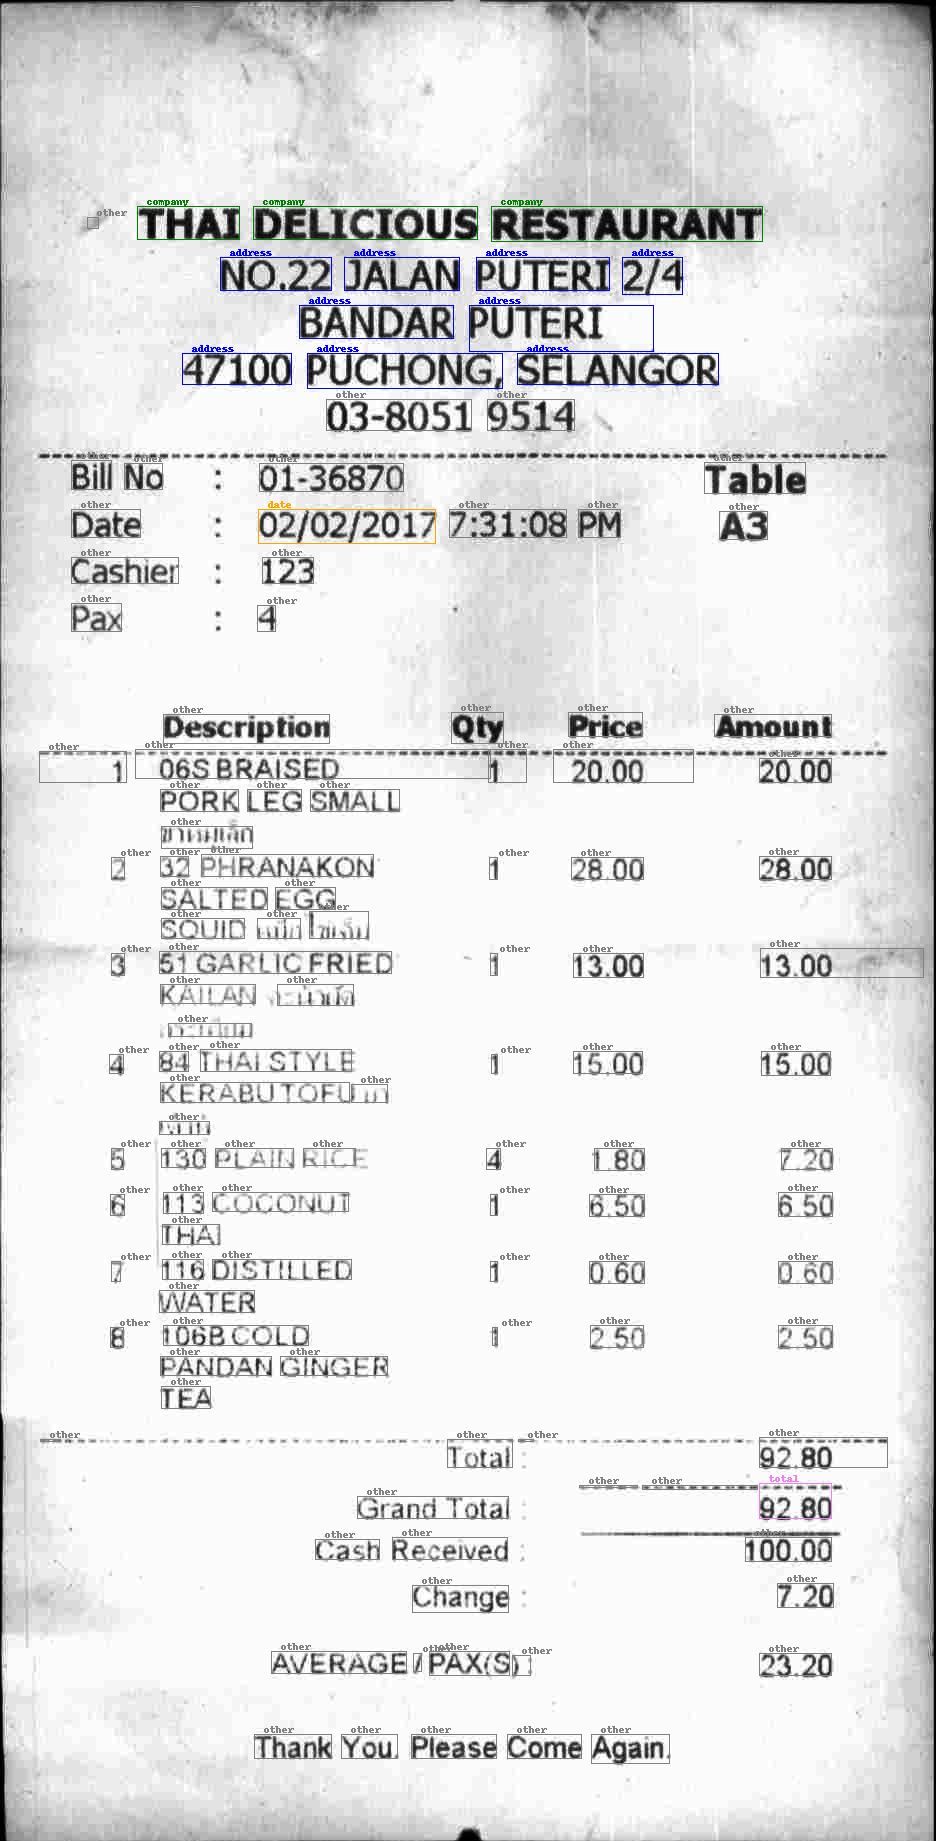

In [ ]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label,
              fill=label2color[predicted_label], font=font)

image

## Teste - criando Json

Rodando o modelo para os dados de teste, e salvando em json

In [ ]:
for i in range(len(test_files)):
    try:
        # abrindo a imagem
        image = Image.open(dataset["test"][i]['image_path'])
        image = image.convert("RGB")
        width, height = image.size

        # criando o arquivo json
        name = dataset["test"][i]['name_file']
        name = re.sub(r'jpg', 'txt', name)

        # mudando o processor para inferência
        processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
        encoded_inputs = processor(image, return_tensors="pt")

        for k, v in encoded_inputs.items():
            encoded_inputs[k] = v.to(device)

        # passando para o modelo
        outputs = model(**encoded_inputs)

        predictions = outputs.logits.argmax(-1).squeeze().tolist()
        token_boxes = encoded_inputs.bbox.squeeze().tolist()
        inputs_ids = encoded_inputs.input_ids.squeeze().tolist()

        # criando um daframe para filtrar os rótulos
        dft = pd.DataFrame({'predictions': predictions, 'input_ids': inputs_ids})
        dft.drop([0], axis=0, inplace=True)
        address = processor.tokenizer.decode(
            dft[dft.predictions == 1]['input_ids'].tolist())
        company = processor.tokenizer.decode(
            dft[dft.predictions == 2]['input_ids'].tolist())
        data = processor.tokenizer.decode(
            dft[dft.predictions == 3]['input_ids'].tolist())
        total = unique_value(processor.tokenizer.decode(
            dft[dft.predictions == 4]['input_ids'].tolist()))


        # removendo espaços indesejados com regex
        address = re.sub(r'((?:(?<=\/) | (?=\/)))|((?:(?<=-) | (?=-)))', '', address).upper()
        company = re.sub(r'((?:(?<=\/) | (?=\/)))|((?:(?<=-) | (?=-)))', '', company).upper()
        data = re.sub(r'((?:(?<=\/) | (?=\/)))|((?:(?<=-) | (?=-)))', '', data).upper()
        data = re.sub(r'(\d\d)(\/|-| |\.)(\d\d)( |\/|.)(\d\d\d?\d?)', r'\1\2\3\2\5', data)
        data = unique_value(data)
        total = re.sub(r'((?:(?<=-) | (?=-)))|((?:(?<=\/) | (?=\/)))|((?:(?<=\.) | (?=\.)))', '', total).upper()


        with open(root_path + 'result/'+ name, 'w') as json_file:
            json.dump({'company': company, 'address': address,
                      'date': data, 'total': total}, json_file, indent=2)
    except:
        print('falha ao salvar ' + root_path + 'result/'+ name)
        with open(root_path + 'result/'+ name, 'w') as json_file:
            json.dump({'company': 'FAILED', 'address': '',
                      'date': '', 'total': ''}, json_file, indent=2)

O resultado pode ser conferido direto no site:  
[Results -  ICDAR 2019](https://rrc.cvc.uab.es/?ch=13&com=evaluation&view=method_samples&task=3&m=92529)

## Referências

*   [Biblioteca Transformers](https://huggingface.co/docs/transformers/index)

*   [Documentação LayoutLMv2](https://huggingface.co/docs/transformers/model_doc/layoutlmv2)

*   [Documentação PyTesseract](https://pypi.org/project/pytesseract/)

*   [Fine-tuning LayoutLMv2ForTokenClassification on FUNSD](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/Fine_tuning_LayoutLMv2ForTokenClassification_on_FUNSD.ipynb)

*   [Extracting Structured Data From Invoice](https://medium.com/analytics-vidhya/extracting-structured-data-from-invoice-96cf5e548e40)

*   [Beginner’s guide to Extract Receipt’s Information using Deep Learning ](https://medium.com/one9-tech/information-extraction-receipt-ocr-scan-deep-learning-1e68ce5a9ae7)